# Explore Gaussian Processes

In [1]:
import pandas as pd
import numpy as np
import feather

DATA_PATH = '/home/SHARED/SOLAR/data/'
#DATA_PATH = '/home/roi/Desktop/'
"""
df = (feather.read_dataframe('/home/SHARED/SOLAR/data/oahu_min.feather')
             .set_index('Datetime'))

info = pd.read_csv('/home/SHARED/SOLAR/data/info.csv')
info['Location'] = info['Location'].str.replace('(HL)?_', '')
info.set_index('Location', inplace=True)
"""
# read minute data and location info
df   = pd.read_pickle(DATA_PATH + 'oahu_min_final.pkl')
info = pd.read_pickle(DATA_PATH + 'info.pkl')
info.sort_index(ascending=True, inplace=True)
info.drop(index = 'AP3', inplace=True)

In [2]:
"""
Returns the training set for the GP, that is the value and location 
of all sensors at a given time
"""
def get_training_set(time='2010-03-19 14:15:00'):
    im = info[['Latitude','Longitude']]
    im['Radiation'] = df.loc[time]
    return im

# Training GPs in Torch

In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Prepare training data

In [4]:
time = '2010-03-19 14:15:00-1000'
im = get_training_set(time)
X = im[['Latitude','Longitude']].values
y = im['Radiation'].values
## Features
train_x = torch.from_numpy(X).double()
# Target
train_y = torch.from_numpy(y).double()

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Model specification

In [31]:
# Simple GP model (RBFKernel)
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

## Training the model

In [32]:
# Find optimal model hyperparameters
model.double()
model.train()
likelihood.train()

verbose = False
# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  
], lr=0.1)

# "Loss" = the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if verbose:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

# Making predictions

In [5]:
def get_grid(latmin, latmax, stepsize):
    long_range = np.arange(lonmin, lonmax, stepsize)
    lat_range = np.arange(latmin, latmax, stepsize)
    latlon =  np.transpose([np.tile(lat_range, len(long_range)), np.repeat(long_range, len(lat_range))])
    grid = pd.DataFrame(latlon, columns=["Latitude", "Longitude"])
    return grid

In [6]:
latmin =  np.min(im.Latitude) - 0.0001
latmax =  np.max(im.Latitude) + 0.0001
lonmin = np.min(im.Longitude) - 0.0001
lonmax = np.max(im.Longitude) + 0.0001
stepsize = 0.0001

grid = get_grid(latmin, latmax, stepsize)

In [7]:
X_test = grid.values
#test_x = torch.from_numpy(X_test).double()
#(y_pred, std_pred) = gpr.predict(X_test, return_std=True)

In [36]:
# Get into evaluation mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.from_numpy(X_test).double()
    observed_pred = likelihood(model(test_x))

In [37]:
grid['prediction'] = observed_pred.mean.numpy()
grid['stds'] = observed_pred.stddev.data.numpy()

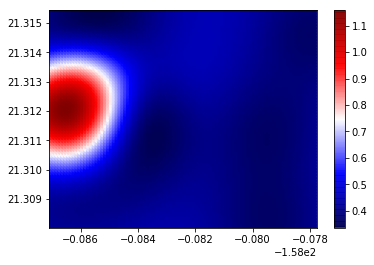

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
##
plt.scatter(grid.Longitude, grid.Latitude, alpha = .8, c = grid.prediction, cmap = 'seismic')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
cbar = plt.colorbar()

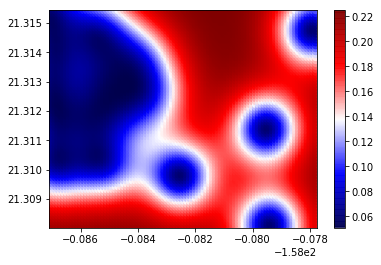

In [13]:
plt.scatter(grid.Longitude, grid.Latitude, alpha = .8, c = grid.stds, cmap = 'seismic')
plt.xlim(lonmin,lonmax)
plt.ylim(latmin,latmax)
cbar = plt.colorbar()

## Wrap everything in single function

In [8]:
def predict_torch(X_train, y_train, X_test, n_epochs=500, verbose=False):
    # Features to torch tensor
    train_x = torch.from_numpy(X_train).double()
    # Target to torch tensor
    train_y = torch.from_numpy(y_train).double()
    # Test features to torch tensor
    test_x = torch.from_numpy(X_test).double()
    ####################################################################
    ## Model specification. Simple GP model (RBFKernel)
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
    ####################################################################
    ## Model training
    # Find optimal model hyperparameters
    model.double()
    model.train()
    likelihood.train()
    #
    # Use the adam optimizer
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},  
    ], lr=0.1)

    # "Loss" = the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    #
    for i in range(n_epochs):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        if verbose:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.item(),
                model.likelihood.noise.item()
            ))
        optimizer.step()
    ####################################################################
    # Make predictions
    # Get into evaluation mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        #test_x = torch.from_numpy(test_x).double()
        observed_pred = likelihood(model(test_x))
        
    return observed_pred.mean.numpy()

In [9]:
mean = predict_torch(X, y, X_test, n_epochs=500, verbose=False)

In [10]:
X_test


array([[  21.30802, -158.0871 ],
       [  21.30812, -158.0871 ],
       [  21.30822, -158.0871 ],
       ...,
       [  21.31522, -158.0778 ],
       [  21.31532, -158.0778 ],
       [  21.31542, -158.0778 ]])